redoing exercise 1 properly

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from tqdm.notebook import tqdm

In [8]:
df = pd.read_csv("law.csv")

In [9]:
def sample(data):
    return data[random.choices(range(len(data)), k=len(data))]

def monte_carlo_bootstrap(f, data, n=40_000):
    return [f(sample(data)) for _ in tqdm(range(n))]


distribution = monte_carlo_bootstrap(lambda x: np.corrcoef(x.T)[0][1], df.values)

  0%|          | 0/40000 [00:00<?, ?it/s]

In [10]:
def monte_carlo_bootstrap_histogram(f, data, n=400_000, bins=1000):
    bins_ = np.linspace(-1, 1, bins)
    distribution = monte_carlo_bootstrap(f, data, n)
    hist, _ = np.histogram(distribution, bins=bins_)
    return hist, bins_

In [11]:
from scipy.ndimage import gaussian_filter1d

def plot_histogram(hist, bins, smoothing=None, ax=None, alpha=1.0, label="Distribution"):
    hist = hist / hist.sum()
    if ax is None:
        ax = plt.subplot()
    if smoothing is None:
        ax.plot(bins[:-1], hist, label=label, alpha=alpha)
    else:
        ax.plot(bins[:-1], gaussian_filter1d(hist, sigma=smoothing), label=label, alpha=alpha)

In [12]:
law_monte_carlo_hist = monte_carlo_bootstrap_histogram(lambda x: np.corrcoef(x.T)[0][1], df.values, n=40_000)

  0%|          | 0/40000 [00:00<?, ?it/s]

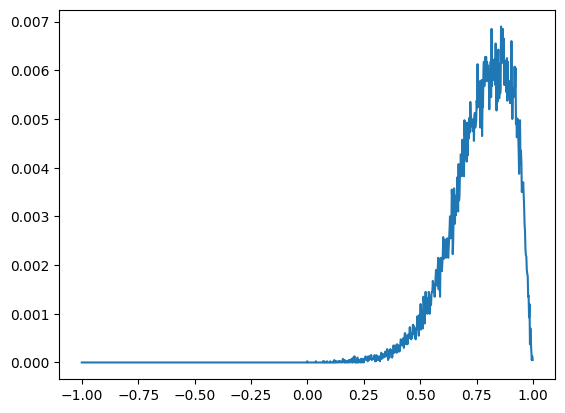

In [13]:
plot_histogram(*law_monte_carlo_hist)

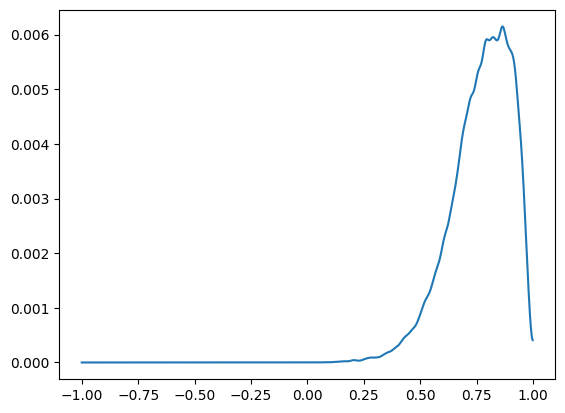

In [14]:
plot_histogram(*law_monte_carlo_hist, smoothing=5)
plt.savefig("law_monte_carlo_hist_5.png")

In [15]:
# fig, ax = plt.subplots()
# for _ in range(5):
#     law_monte_carlo_hist = monte_carlo_bootstrap_histogram(lambda x: np.corrcoef(x.T)[0][1], df.values, n=700_000)
#     plot_histogram(*law_monte_carlo_hist, smoothing=5, ax=ax)
# ax.legend()
# plt.savefig("law_monte_carlo_hist_all_5.png")
# plt.show()

In [16]:
from itertools import combinations_with_replacement
from scipy.stats import multinomial
from joblib import Parallel, delayed

def complete_enumeration_bootstrap(f, data):
    n = len(data)
    # get all possible combinations of the data
    combinations = list(combinations_with_replacement(range(n), n))
    # calculate the statistic for each combination
    distribution = np.array([f(data[list(c)]) for c in tqdm(combinations)])
    # calculate the probabilities of each combination
    probabilities = [multinomial.pmf(np.bincount(c, minlength=n), n, [1/n]*n) for c in tqdm(combinations)]
    return distribution, probabilities

def complete_enumeration_bootstrap_histogram(f, data, bins=1000, parallelized=False):
    # get the distribution and probabilities
    if parallelized:
        distribution, probabilities = complete_enumeration_bootstrap_parallelized(f, data)
    else:
        distribution, probabilities = complete_enumeration_bootstrap(f, data)
    # bin the distribution
    bins_ = np.linspace(-1, 1, bins)
    hist, _ = np.histogram(distribution, bins=bins_, weights=probabilities)
    return hist, bins_

![](img/2023-03-21-22-51-27.png)

In [21]:
law_monte_carlo_hist = monte_carlo_bootstrap_histogram(lambda x: np.corrcoef(x.T)[0][1], df.values, n=400_000)

  0%|          | 0/400000 [00:00<?, ?it/s]

In [18]:
# for complete enumeration load distribution and probabilities from file
import numpy as np
dist, probs = np.load("law_complete_enumeration_hist.npy")
# get the bins
bins_ = np.linspace(-1, 1, 1000)
# bin the distribution
hist, _ = np.histogram(dist, bins=bins_, weights=probs)
law_complete_enumeration_hist = hist, bins_


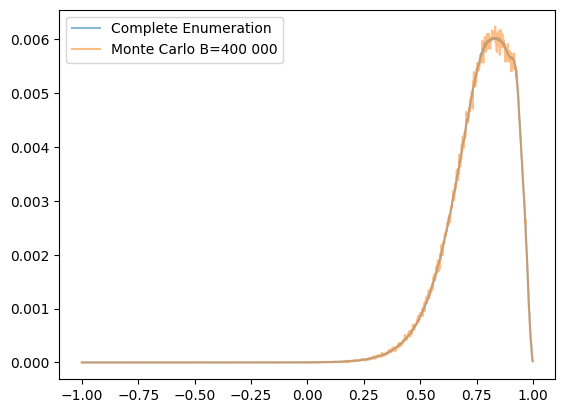

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plot_histogram(*law_complete_enumeration_hist, smoothing=None, ax=ax, alpha=0.5, label="Complete Enumeration")
plot_histogram(*law_monte_carlo_hist, smoothing=None, ax=ax, alpha=0.5, label="Monte Carlo B=400 000")
ax.legend()
plt.savefig("complete_vs_monte_carlo.png")
plt.show()

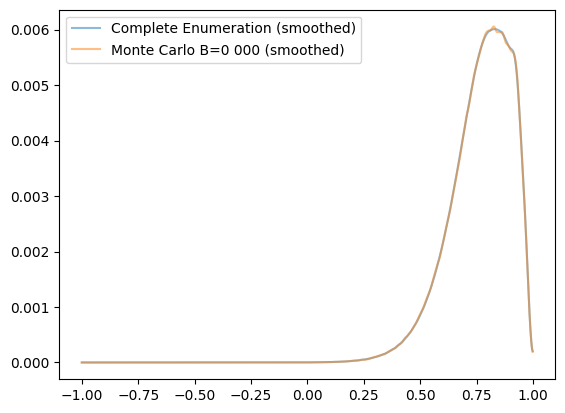

In [33]:
fig, ax = plt.subplots()
plot_histogram(*law_complete_enumeration_hist, smoothing=3, ax=ax, alpha=0.5, label="Complete Enumeration (smoothed)")
plot_histogram(*law_monte_carlo_hist, smoothing=3, ax=ax, alpha=0.5, label="Monte Carlo B=0 000 (smoothed)")
ax.legend()
plt.savefig("complete_vs_monte_carlo_smooth.png")
plt.show()